In [1]:
!pip install git+https://github.com/Farama-Foundation/MAgent2
!git clone https://github.com/giangbang/RL-final-project-AIT-3007.git

  Cloning https://github.com/Farama-Foundation/MAgent2 to /tmp/pip-req-build-12or0hnj
  Running command git clone --filter=blob:none --quiet https://github.com/Farama-Foundation/MAgent2 /tmp/pip-req-build-12or0hnj
  Resolved https://github.com/Farama-Foundation/MAgent2 to commit b2ddd49445368cf85d4d4e1edcddae2e28aa1406
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for magent2: filename=magent2-0.3.3-cp310-cp310-linux_x86_64.whl size=1696074 sha256=b300e0ed0a193a756bb6cf955ba19ad523b366fcdbd27920d691e19b4c1861d7
  Stored in directory: /tmp/pip-ephem-wheel-cache-bkc5knp9/wheels/e4/8e/bf/51a30bc4038546e23b81c9fb513fe6a8fd916e5a9c5f4291d5
Successfully built magent2
Cloning into 'RL-final-project-AIT-3007'...
remote: Enumerating objects: 56, done.
remote: Counting objects: 100% (26/26), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 56 (delta 17), reused 11 (delta 1

In [2]:
import sys
sys.path.append('RL-final-project-AIT-3007')

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import random
from collections import deque, Counter, defaultdict
import os
from magent2.environments import battle_v4
import time

In [4]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.buffer = deque(maxlen=capacity)

    def add(self, state, action, reward, next_state, done):
        experience = (state, action, reward, next_state, done)
        self.buffer.append(experience)

    def __len__(self):
        return len(self.buffer)

    def __getitem__(self, index):
        return self.buffer[index]

class MyQNetwork(nn.Module):
    def __init__(self, observation_shape, action_shape):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(observation_shape[-1], 8, kernel_size=3, padding=1, stride=1),
            nn.ReLU(),
            nn.Conv2d(8, 8, kernel_size=3, padding=1, stride=1),
            nn.ReLU(),
        )

        dummy_input = torch.randn(observation_shape).permute(2, 0, 1)
        dummy_output = self.cnn(dummy_input)
        flatten_dim = dummy_output.view(-1).shape[0]

        self.fc = nn.Sequential(
            nn.Linear(flatten_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, action_shape)
        )

    def forward(self, x):
        assert len(x.shape) >= 3, "only support magent input observation"
        out = self.cnn(x)

        if len(x.shape) == 3:
            batchsize = 1
        else:
            batchsize = x.shape[0]

        out = out.reshape(batchsize, -1)
        return self.fc(out)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [7]:
import torch
import torch.optim.lr_scheduler as lr_scheduler
import numpy as np
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

class Trainer:
    def __init__(self, env, config_qnet=None, input_shape=None, action_shape=None, learning_rate=1e-3):
        self.env = env
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.q_network = MyQNetwork(input_shape, action_shape).to(self.device)

        self.target_network = MyQNetwork(input_shape, action_shape).to(self.device)
        self.target_network.load_state_dict(self.q_network.state_dict())

        self.criterion = nn.MSELoss()
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=learning_rate)
        self.steplr = lr_scheduler.StepLR(optimizer=self.optimizer, step_size=1, gamma=0.9)
        self.replay_buffer = ReplayBuffer(capacity=60000)

        self.gamma = 0.9
        self.epsilon = 1.0
        self.epsilon_min = 0.1
        self.epsilon_decay = 0.97
        self.update_target_every = 3

        self.blue_rewards_history = []
        self.red_rewards_history = []

    def select_action(self, observation, agent):
        if np.random.rand() <= self.epsilon:
            return self.env.action_space(agent).sample()

        observation = torch.FloatTensor(observation).unsqueeze(0).to(self.device)

        with torch.inference_mode():
            q_values = self.q_network(observation)

        if np.random.rand() <= self.epsilon * 0.1:  
            exp_q_values = torch.exp(q_values).cpu().numpy().flatten()
            action_probabilities = exp_q_values / exp_q_values.sum()  
            return np.random.choice(len(action_probabilities), p=action_probabilities)

        return torch.argmax(q_values, dim=1).item()

    def training(self, episodes=100, batch_size=1024):
            start_time = time.time()  
            for episode in range(episodes):
                self.env.reset()
                total_blue_reward = 0
                total_red_reward = 0
                reward_for_agent = {agent: 0 for agent in self.env.agents if agent.startswith('blue')}
                prev_observation = {}
                prev_action = {}
                step = 0
    
                for idx, agent in enumerate(self.env.agent_iter()):
                    step += 1
                    observation, reward, termination, truncation, info = self.env.last()
                    observation = np.transpose(observation, (2, 0, 1))
    
                    agent_handle = agent.split('_')[0]
    
                    if agent_handle == 'blue':
                        total_blue_reward += reward
                        reward_for_agent[agent] += reward
                    elif agent_handle == 'red':
                        total_red_reward += reward
    
                    if termination or truncation:
                        action = None
                    else:
                        if agent_handle == 'blue':
                            action = self.select_action(observation, agent)  
                        else:
                            action = self.env.action_space(agent).sample()
    
                    if agent_handle == 'blue':
                        if agent in prev_observation and agent in prev_action:
                            self.replay_buffer.add(
                                prev_observation[agent],
                                prev_action[agent],
                                reward,
                                observation,
                                termination
                            )
    
                        prev_observation[agent] = observation
                        prev_action[agent] = action
    
                    self.env.step(action)
    
                if len(self.replay_buffer) >= batch_size:
                    dataloader = DataLoader(self.replay_buffer, batch_size=batch_size, shuffle=True, drop_last=True)
                    self.update_model(dataloader)
    
                if (episode + 1) % self.update_target_every == 0:
                    self.target_network.load_state_dict(self.q_network.state_dict())
                    self.steplr.step()
    
                self.blue_rewards_history.append(total_blue_reward)
                self.red_rewards_history.append(total_red_reward)
    
                elapsed_time = time.time() - start_time  # Tính thời gian huấn luyện
                print(f"Episode {episode + 1}: Blue Reward: {total_blue_reward}, Red Reward: {total_red_reward}, "
                      f"Steps: {step}, Epsilon: {self.epsilon:.2f}, lr: {self.steplr.get_last_lr()}")
    
                self.epsilon = max(self.epsilon * self.epsilon_decay, self.epsilon_min)
    
            total_training_time = time.time() - start_time  
            print(f"training time: {total_training_time:.2f}s")

    def update_model(self, dataloader):
        self.q_network.train()
        for states, actions, rewards, next_states, dones in dataloader:
            states = states.to(dtype=torch.float32, device=self.device)
            actions = actions.to(dtype=torch.long, device=self.device)
            rewards = rewards.to(dtype=torch.float32, device=self.device)
            next_states = next_states.to(dtype=torch.float32, device=self.device)
            dones = dones.to(dtype=torch.float32, device=self.device)

            current_q_values = self.q_network(states).gather(1, actions.unsqueeze(1)).squeeze(1)

            with torch.inference_mode():
                next_actions = self.q_network(next_states).argmax(1)
                next_q_values = self.target_network(next_states).gather(1, next_actions.unsqueeze(1)).squeeze(1)

            expected_q_values = rewards + (self.gamma * next_q_values * (1 - dones))

            loss = self.criterion(current_q_values, expected_q_values)
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

    def plot_results(self):
        plt.figure(figsize=(12, 6))

        plt.subplot(1, 2, 1)
        plt.plot(self.blue_rewards_history, label="Blue Team Reward", color="blue")
        plt.plot(self.red_rewards_history, label="Red Team Reward", color="red")
        plt.xlabel("Episodes")
        plt.ylabel("Rewards")
        plt.title("Rewards per Episode")
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(self.smooth(self.blue_rewards_history), label="Smoothed Blue Team Reward", color="blue")
        plt.plot(self.smooth(self.red_rewards_history), label="Smoothed Red Team Reward", color="red")
        plt.xlabel("Episodes")
        plt.ylabel("Rewards")
        plt.title("Smoothed Rewards per Episode")
        plt.legend()

        plt.tight_layout()
        plt.show()

    @staticmethod
    def smooth(data, window_size=10):
        if len(data) < window_size:
            return data
        return np.convolve(data, np.ones(window_size)/window_size, mode='valid')


Episode 1: Blue Reward: -3271.790119255893, Red Reward: -3254.16511900723, Steps: 160837, Epsilon: 1.00, lr: [0.001]
Episode 2: Blue Reward: -3144.2801143648103, Red Reward: -3202.265117334202, Steps: 158599, Epsilon: 0.97, lr: [0.001]
Episode 3: Blue Reward: -3170.1801139190793, Red Reward: -3303.2601191550493, Steps: 159536, Epsilon: 0.94, lr: [0.0009000000000000001]
Episode 4: Blue Reward: -3035.3951086960733, Red Reward: -3324.950120622292, Steps: 159716, Epsilon: 0.91, lr: [0.0009000000000000001]
Episode 5: Blue Reward: -2938.050106056966, Red Reward: -3131.2751131569967, Steps: 155983, Epsilon: 0.89, lr: [0.0009000000000000001]
Episode 6: Blue Reward: -2740.620099452324, Red Reward: -3021.300110134296, Steps: 150848, Epsilon: 0.86, lr: [0.0008100000000000001]
Episode 7: Blue Reward: -2888.200100766495, Red Reward: -3317.83011917118, Steps: 160352, Epsilon: 0.83, lr: [0.0008100000000000001]
Episode 8: Blue Reward: -2690.1600938802585, Red Reward: -3288.50012073759, Steps: 160117, 

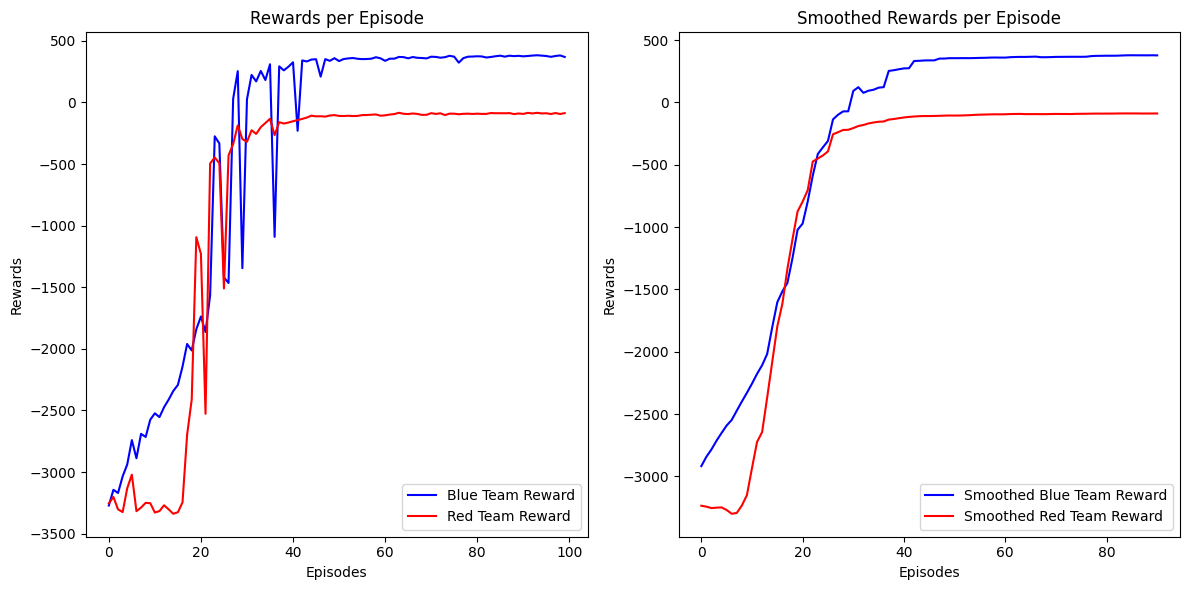

In [8]:
env = battle_v4.env(map_size=45, render_mode=None)
trainer = Trainer(env, input_shape=env.observation_space("red_0").shape, action_shape=env.action_space("red_0").n)
trainer.training(episodes=100)
trainer.plot_results()

In [9]:
os.makedirs("RL-final-project-AIT-3007", exist_ok=True)
torch.save(trainer.q_network.state_dict(), "RL-final-project-AIT-3007/blue_final.pt")
print("Training complete. Model saved.")

Training complete. Model saved.


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [10]:
import final_torch_model
import torch_model

# from torch_model import QNetwork
try:
    from tqdm import tqdm
except ImportError:
    tqdm = lambda x, *args, **kwargs: x  # Fallback: tqdm becomes a no-op

def eval():
    max_cycles = 300
    env = battle_v4.env(map_size=45, max_cycles=max_cycles)
    device = "cuda" if torch.cuda.is_available() else "cpu"

    ### Load my network
    MyNetwork = MyQNetwork(observation_shape=env.observation_space("red_0").shape, action_shape=env.action_space("red_0").n)
    MyNetwork.load_state_dict(
        torch.load(
            "RL-final-project-AIT-3007/blue_final.pt",
            weights_only=True,
            map_location="cpu"
        )
    )
    MyNetwork.to(device)

    ### Load red_final model
    red_final_network = final_torch_model.QNetwork(
        env.observation_space("red_0").shape, env.action_space("red_0").n
    )
    red_final_network.load_state_dict(
        torch.load(
            "RL-final-project-AIT-3007/red_final.pt",
            weights_only=True,
            map_location="cpu"
        )
    )
    red_final_network = red_final_network.to(device)

    ### Load red model
    red_network = torch_model.QNetwork(
        env.observation_space("red_0").shape, env.action_space("red_0").n
    )
    red_network.load_state_dict(
        torch.load(
            "RL-final-project-AIT-3007/red.pt",
            weights_only=True,
            map_location="cpu"
        )
    )
    red_network = red_network.to(device)

    def random_policy(env, agent, obs):
        return env.action_space(agent).sample()

    def red_final_policy(env, agent, obs):
        observation = (
            torch.Tensor(obs).float().permute([2, 0, 1]).unsqueeze(0).to(device)
        )
        red_final_network.eval()
        with torch.inference_mode():
            q_values = red_final_network(observation)
        return torch.argmax(q_values, dim=1).cpu().numpy()[0]

    def red_policy(env, agent, obs):
        observation = (
            torch.Tensor(obs).float().permute([2, 0, 1]).unsqueeze(0).to(device)
        )
        red_network.eval()
        with torch.inference_mode():
            q_values = red_network(observation)
        return torch.argmax(q_values, dim=1).cpu().numpy()[0]

    def my_policy(env, agent, obs):
        observation = (
            torch.Tensor(obs).float().permute([2, 0, 1]).unsqueeze(0).to(device)
        )
        MyNetwork.eval()
        with torch.inference_mode():
            q_values = MyNetwork(observation)
        return torch.argmax(q_values, dim=1).cpu().numpy()[0]

    # def policy()

    def run_eval(env, red_policy, blue_policy, n_episode: int = 100):
        red_win, blue_win = [], []
        red_tot_rw, blue_tot_rw = [], []
        n_agent_each_team = len(env.env.action_spaces) // 2

        for _ in tqdm(range(n_episode)):
            env.reset()
            n_kill = {"red": 0, "blue": 0}
            red_reward, blue_reward = 0, 0

            for agent in env.agent_iter():
                observation, reward, termination, truncation, info = env.last()
                agent_team = agent.split("_")[0]

                n_kill[agent_team] += (
                    reward > 4.5
                )  # This assumes default reward settups
                if agent_team == "red":
                    red_reward += reward
                else:
                    blue_reward += reward

                if termination or truncation:
                    action = None  # this agent has died
                else:
                    if agent_team == "red":
                        action = red_policy(env, agent, observation)
                    else:
                        action = blue_policy(env, agent, observation)

                env.step(action)

            who_wins = "red" if n_kill["red"] >= n_kill["blue"] + 5 else "draw"
            who_wins = "blue" if n_kill["red"] + 5 <= n_kill["blue"] else who_wins
            red_win.append(who_wins == "red")
            blue_win.append(who_wins == "blue")

            red_tot_rw.append(red_reward / n_agent_each_team)
            blue_tot_rw.append(blue_reward / n_agent_each_team)

        return {
            "winrate_red": np.mean(red_win),
            "winrate_blue": np.mean(blue_win),
            "average_rewards_red": np.mean(red_tot_rw),
            "average_rewards_blue": np.mean(blue_tot_rw),
        }

    print("=" * 20)
    print("Eval with red final policy")
    print(
        run_eval(
            env=env, red_policy=red_final_policy, blue_policy=my_policy, n_episode=30
        )
    )

    print("=" * 20)
    print("Eval with red policy")
    print(
        run_eval(
            env=env, red_policy=red_policy, blue_policy=my_policy, n_episode=30
        )
    )

    print("=" * 20)
    print("Eval with random policy")
    print(
        run_eval(
            env=env, red_policy=random_policy, blue_policy=my_policy, n_episode=30
        )
    )

    print("=" * 20)

if __name__ == "__main__":
    eval()

/usr/local/lib/python3.10/dist-packages/pettingzoo/utils/wrappers/base.py:72: UserWarning: The `action_spaces` dictionary is deprecated. Use the `action_space` function instead.
  warnings.warn(


Eval with red final policy


100%|██████████| 30/30 [01:57<00:00,  3.92s/it]


{'winrate_red': 0.0, 'winrate_blue': 1.0, 'average_rewards_red': 1.7961851705099483, 'average_rewards_blue': 4.904901208401632}
Eval with red policy


100%|██████████| 30/30 [01:15<00:00,  2.51s/it]


{'winrate_red': 0.0, 'winrate_blue': 1.0, 'average_rewards_red': 0.8998333279008942, 'average_rewards_blue': 4.958917665088726}
Eval with random policy


100%|██████████| 30/30 [00:55<00:00,  1.86s/it]

{'winrate_red': 0.0, 'winrate_blue': 1.0, 'average_rewards_red': -0.9472860419616839, 'average_rewards_blue': 4.9558723962589815}
